In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

## Verilənlərin yüklənməsi və hazırlanması

In [18]:
df = pd.read_csv('c:/Users/salim/Desktop/Data Science/Mentor/turbo_az.csv')
df.head(3)

,Avtosalon,Qiymet,Valyuta,Şəhər,Marka,Model,Buraxılış ili,Ban növü,Rəng,Mühərrik,...,Yeni,Vəziyyəti,Yeniləndi,Baxışların sayı,Extra,Etrafli,Sahiblər,Hansı bazar üçün yığılıb,Yerlərin sayı,Qəzalı
0,0,13500,AZN,Bakı,Opel,Vectra,2000,Hetçbek,Göy,1.6 L/101 a.g./Benzin,...,Xeyr,"Vuruğu yoxdur, rənglənib",28.05.2023,267,"Yüngül lehimli disklər, ABS, Kondisioner, Dəri...",Salam Barter mümkündür. 1.6 sadə mator mexanik...,2,Avropa,5,NaN
1,1,23500,USD,Bakı,Toyota,Corolla,2023,Sedan,Mavi,1.8 L/178 a.g./Hibrid,...,Bəli,"Vuruğu yoxdur, rənglənməyib",28.05.2023,12410,"Yüngül lehimli disklər, ABS, Yağış sensoru, Mə...",TOYOTA CAROLLA 2023 ALIŞ. 2 İL 80.000 KM ZƏMAN...,1,Rəsmi diler,5,NaN
2,0,33200,AZN,Bakı,Hyundai,Santa Fe,2013,Offroader / SUV,Qara,2.0 L/184 a.g./Dizel,...,Xeyr,"Vuruğu yoxdur, rənglənməyib",28.05.2023,148,"Yüngül lehimli disklər, ABS, Lyuk, Yağış senso...",Yeni gelib bakida surlmuyb qiymet mawin yanind...,1,Avropa,7,NaN


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Avtosalon                 10000 non-null  int64 
 1   Qiymet                    10000 non-null  int64 
 2   Valyuta                   10000 non-null  object
 3   Şəhər                     10000 non-null  object
 4   Marka                     10000 non-null  object
 5   Model                     10000 non-null  object
 6   Buraxılış ili             10000 non-null  int64 
 7   Ban növü                  10000 non-null  object
 8   Rəng                      10000 non-null  object
 9   Mühərrik                  10000 non-null  object
 10  Yürüş                     10000 non-null  object
 11  Sürətlər qutusu           10000 non-null  object
 12  Ötürücü                   10000 non-null  object
 13  Yeni                      10000 non-null  object
 14  Vəziyyəti              

In [20]:
df.describe()

,Avtosalon,Qiymet,Buraxılış ili,Baxışların sayı
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.25370,27318.521400,2010.067900,4328.818800
std,0.43515,28995.789851,8.386246,13383.511716
min,0.00000,1100.000000,1938.000000,41.000000
25%,0.00000,12700.000000,2006.000000,408.750000
50%,0.00000,21000.000000,2011.000000,1164.500000
75%,1.00000,32500.000000,2015.000000,3500.250000
max,1.00000,850000.000000,2023.000000,334547.000000


In [3]:
df_clean = df.copy()

# Qiymətləri AZN-ə çevirək
df_clean['qiymet_azn'] = df_clean['Qiymet']
# USD qiymətləri AZN-ə çevirək (1 USD = 1.7 AZN)
mask_usd = df_clean['Valyuta'] == 'USD'
df_clean.loc[mask_usd, 'qiymet_azn'] = df_clean.loc[mask_usd, 'Qiymet'] * 1.7
# EUR qiymətləri AZN-ə çevirək (1 EUR = 1.85 AZN)
mask_eur = df_clean['Valyuta'] == 'EUR'
df_clean.loc[mask_eur, 'qiymet_azn'] = df_clean.loc[mask_eur, 'Qiymet'] * 1.85

# Sütun adlarını kiçik hərflərə çevirək
df_clean.columns = [col.lower() for col in df_clean.columns]

# Avtomobil yaşını hesablayaq
current_year = 2025
df_clean['avtomobil_yasi'] = current_year - df_clean['buraxılış ili']

# Mühərrik həcmini ədədi dəyərə çevirək
df_clean['muherrik_hecmi'] = df_clean['mühərrik'].str.extract(r'(\d+\.?\d*)').astype(float)

# At gücünü çıxaraq
df_clean['at_gucu'] = df_clean['mühərrik'].str.extract(r'(\d+)\s*a\.g').fillna(0).astype(int)

# Yürüşü ədədi dəyərə çevirək (km)
df_clean['yurus_km'] = df_clean['yürüş'].str.extract(r'(\d+)').astype(float)

# Kateqorik dəyişənləri one-hot encoding ilə kodlaşdıraq
cat_cols = ['şəhər', 'ban növü', 'rəng', 'sürətlər qutusu', 'ötürücü', 'yeni']
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

# Lazımsız sütunları silək
cols_to_drop = ['avtosalon', 'qiymet', 'valyuta', 'marka', 'model', 'mühərrik', 'yürüş', 
                'vəziyyəti', 'yeniləndi', 'baxışların sayı', 'extra', 'etrafli', 
                'sahiblər', 'hansı bazar üçün yığılıb', 'yerlərin sayı', 'qəzalı']
df_encoded = df_encoded.drop(columns=cols_to_drop, errors='ignore')

# NaN dəyərləri olan sətirləri silək
df_encoded = df_encoded.dropna()

# Outlier-ləri təmizləyək (qiymət üçün)
Q1 = df_encoded['qiymet_azn'].quantile(0.01)
Q3 = df_encoded['qiymet_azn'].quantile(0.99)
df_encoded = df_encoded[(df_encoded['qiymet_azn'] >= Q1) & (df_encoded['qiymet_azn'] <= Q3)]

print(f"Təmizlənmiş verilənlərin ölçüsü: {df_encoded.shape}")
df_encoded.head()

Təmizlənmiş verilənlərin ölçüsü: (9808, 106)


C:\Users\salim\AppData\Local\Temp\ipykernel_5384\875219192.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 39950.  61200.  45050. ...  51000.  38930. 166600.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[mask_usd, 'qiymet_azn'] = df_clean.loc[mask_usd, 'Qiymet'] * 1.7


,buraxılış ili,qiymet_azn,avtomobil_yasi,muherrik_hecmi,at_gucu,yurus_km,şəhər_Ağcabədi,şəhər_Ağdam,şəhər_Ağdaş,şəhər_Ağstafa,...,rəng_Tünd qırmızı,rəng_Yaş Asfalt,rəng_Yaşıl,rəng_Çəhrayı,sürətlər qutusu_Mexaniki,sürətlər qutusu_Robotlaşdırılmış,sürətlər qutusu_Variator,ötürücü_Tam,ötürücü_Ön,yeni_Xeyr
0,2000,13500.0,25,1.6,101,370.0,False,False,False,False,...,False,False,False,False,True,False,False,False,True,True
1,2023,39950.0,2,1.8,178,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2013,33200.0,12,2.0,184,168.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3,2015,17000.0,10,1.5,181,120.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
4,2022,61200.0,3,2.0,173,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## Verilənlərin hazırlanması

In [4]:
X = df_encoded.drop('qiymet_azn', axis=1)
y = df_encoded['qiymet_azn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Təlim verilənlərinin ölçüsü: {X_train.shape}")
print(f"Test verilənlərinin ölçüsü: {X_test.shape}")

Təlim verilənlərinin ölçüsü: (7846, 105)
Test verilənlərinin ölçüsü: (1962, 105)


## Model qiymətləndirmə funksiyası

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\n{model_name} modeli təlim edilir...")
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"Təlim RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Təlim MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Təlim R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Faktiki qiymət (AZN)')
    plt.ylabel('Proqnozlaşdırılmış qiymət (AZN)')
    plt.title(f'{model_name}: Faktiki və proqnozlaşdırılmış qiymətlərin müqayisəsi')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

## 1. Decision Tree Regressor


Decision Tree modeli təlim edilir...
Təlim RMSE: 1502.05
Test RMSE: 15493.42
Təlim MAE: 147.76
Test MAE: 6824.81
Təlim R²: 0.9982
Test R²: 0.8074


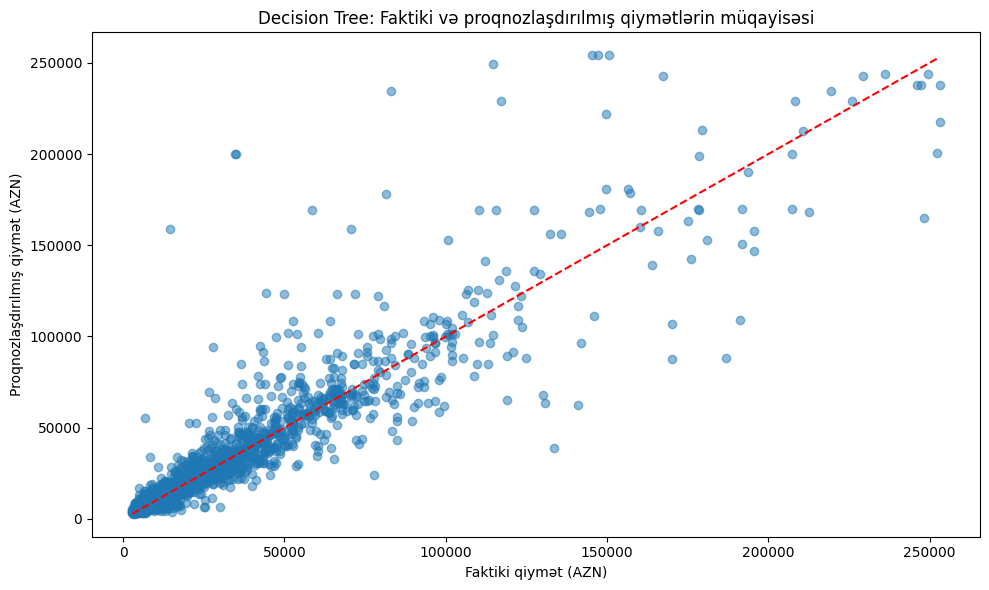

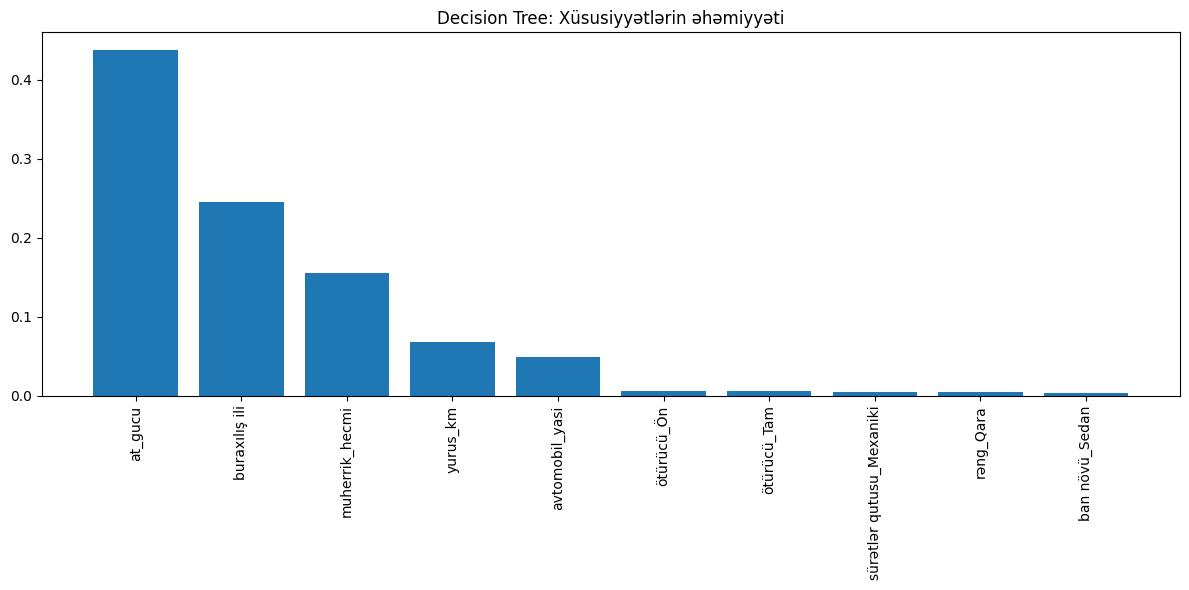

In [6]:
dt = DecisionTreeRegressor(random_state=42)
dt_results = evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")

feature_importances = dt.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Decision Tree: Xüsusiyyətlərin əhəmiyyəti')
plt.bar(range(10), feature_importances[indices[:10]], align='center')
plt.xticks(range(10), feature_names[indices[:10]], rotation=90)
plt.tight_layout()
plt.show()

## 2. Random Forest Regressor


Random Forest modeli təlim edilir...
Təlim RMSE: 4192.64
Test RMSE: 11660.95
Təlim MAE: 1934.35
Test MAE: 5343.85
Təlim R²: 0.9859
Test R²: 0.8909


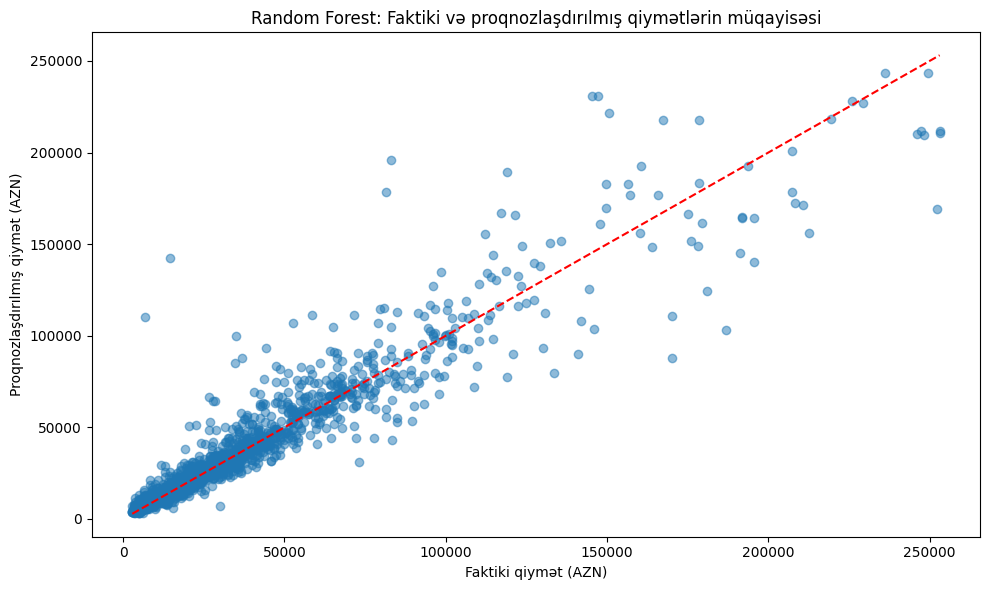

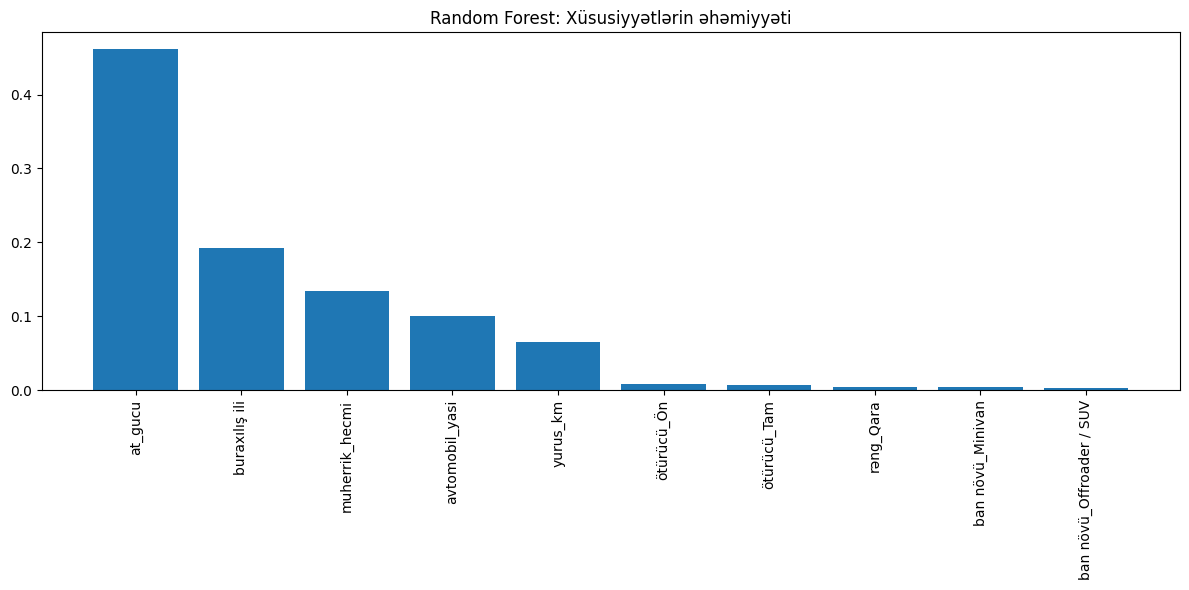

In [7]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

feature_importances = rf.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Random Forest: Xüsusiyyətlərin əhəmiyyəti')
plt.bar(range(10), feature_importances[indices[:10]], align='center')
plt.xticks(range(10), feature_names[indices[:10]], rotation=90)
plt.tight_layout()
plt.show()

## 3. Support Vector Regression (SVR)


Support Vector Regression modeli təlim edilir...
Təlim RMSE: 29439.03
Test RMSE: 29410.75
Təlim MAE: 14331.92
Test MAE: 14168.84
Təlim R²: 0.3053
Test R²: 0.3061


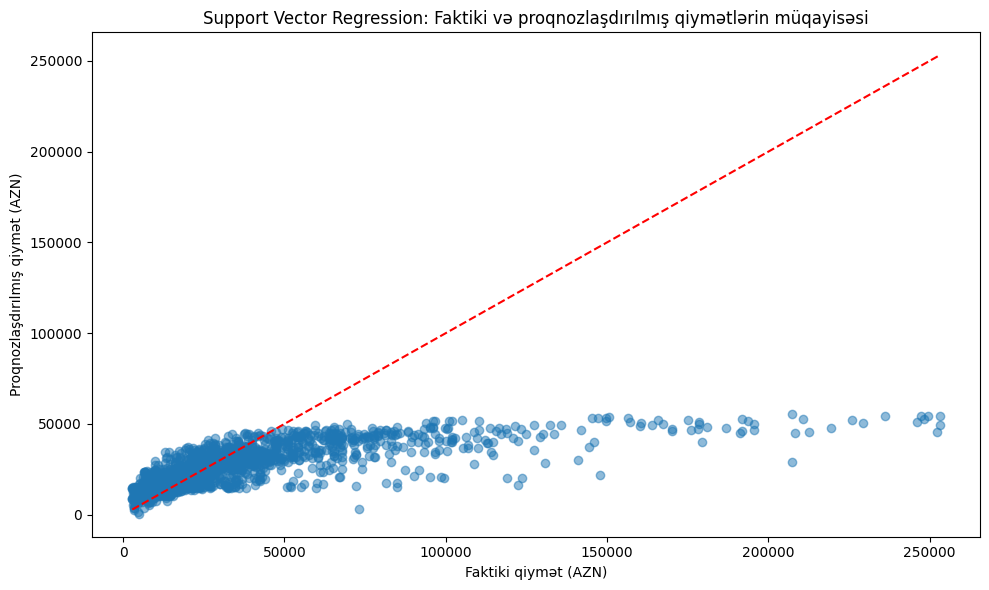

In [8]:
svr = SVR(kernel='rbf', C=100, gamma='scale')
svr_results = evaluate_model(svr, X_train_scaled, X_test_scaled, y_train, y_test, "Support Vector Regression")

## 4. K-Nearest Neighbors (KNN) Regressor


K-Nearest Neighbors modeli təlim edilir...

K-Nearest Neighbors modeli təlim edilir...
Təlim RMSE: 12157.35
Test RMSE: 14044.56
Təlim MAE: 6255.18
Test MAE: 7591.81
Təlim R²: 0.8815
Test R²: 0.8418


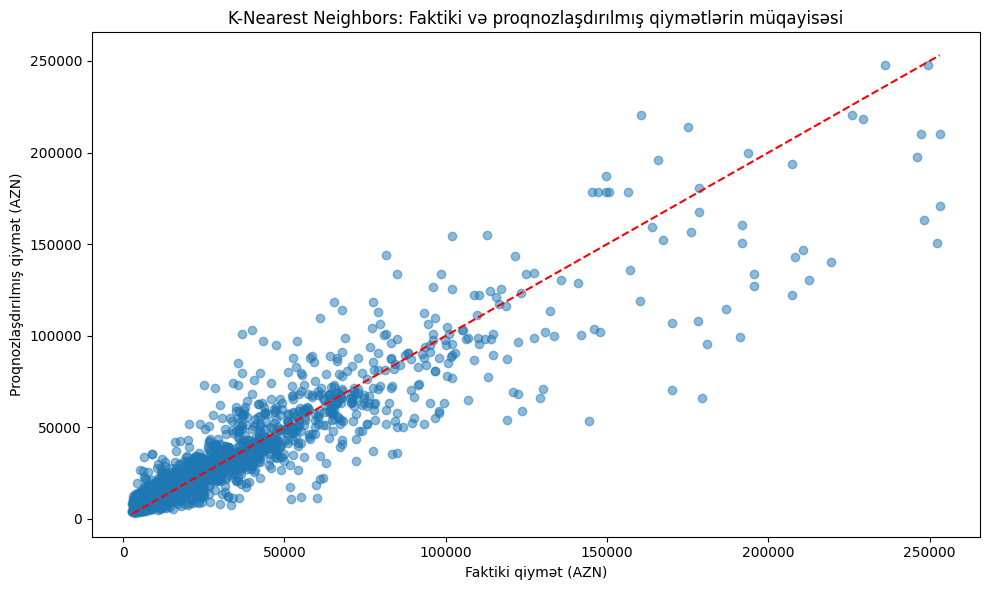

In [12]:
print("\nK-Nearest Neighbors modeli təlim edilir...")
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=1)
knn_results = evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test, "K-Nearest Neighbors")

## Modellərin müqayisəsi

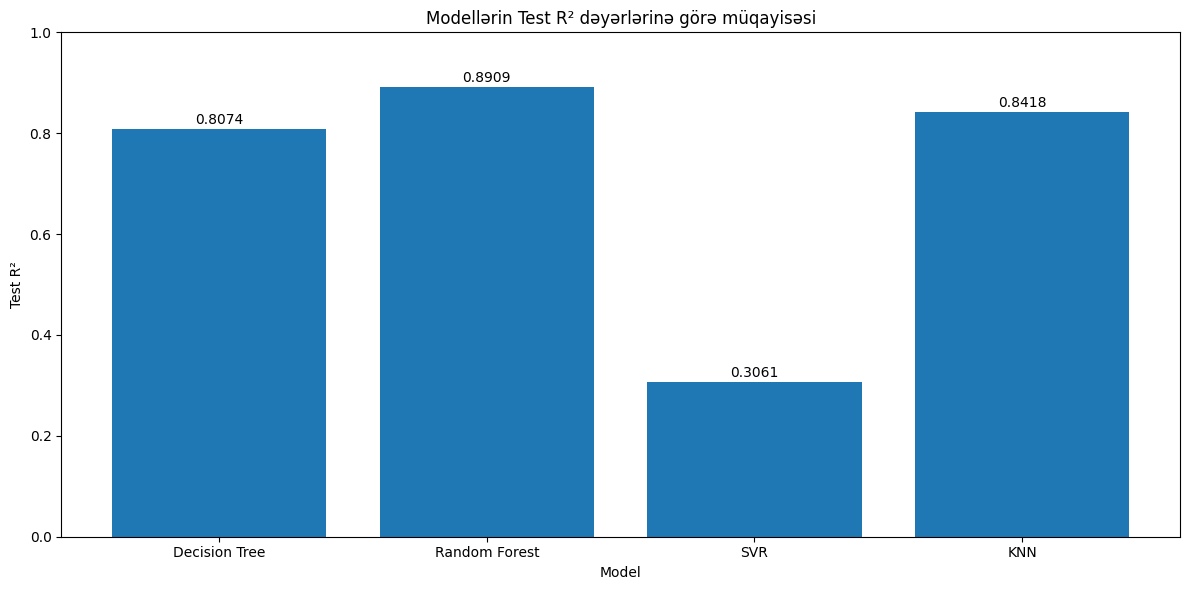

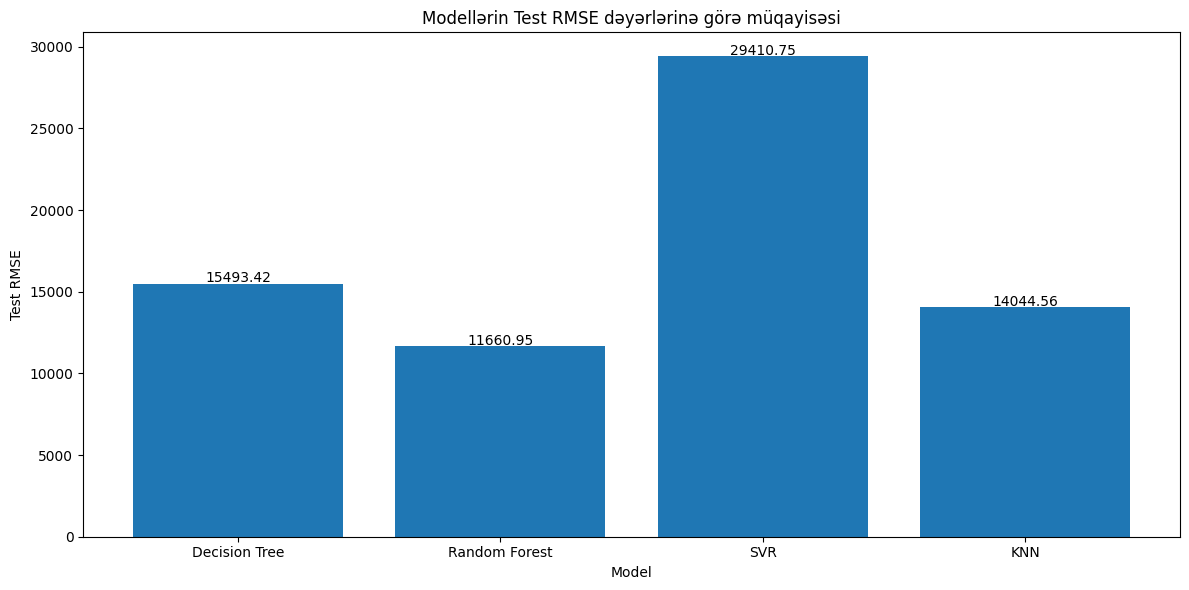


Ən yaxşı model: Random Forest (Test R² = 0.8909)


In [10]:
models = ['Decision Tree', 'Random Forest', 'SVR', 'KNN']
results = [dt_results, rf_results, svr_results, knn_results]

test_r2_values = [result['test_r2'] for result in results]
test_rmse_values = [result['test_rmse'] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(models, test_r2_values)
plt.title('Modellərin Test R² dəyərlərinə görə müqayisəsi')
plt.xlabel('Model')
plt.ylabel('Test R²')
plt.ylim(0, 1)
for i, v in enumerate(test_r2_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(models, test_rmse_values)
plt.title('Modellərin Test RMSE dəyərlərinə görə müqayisəsi')
plt.xlabel('Model')
plt.ylabel('Test RMSE')
for i, v in enumerate(test_rmse_values):
    plt.text(i, v + 100, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Ən yaxşı modeli seçək
best_model_index = np.argmax(test_r2_values)
best_model_name = models[best_model_index]
print(f"\nƏn yaxşı model: {best_model_name} (Test R² = {test_r2_values[best_model_index]:.4f})")

## Ən yaxşı modelin hiperparametr optimizasiyası

In [11]:
if best_model_name == 'Decision Tree':
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = DecisionTreeRegressor(random_state=42)
    X_best = X_train
    X_best_test = X_test
    
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    best_model = RandomForestRegressor(random_state=42)
    X_best = X_train
    X_best_test = X_test
    
elif best_model_name == 'Support Vector Regression':
    param_grid = {
        'C': [10, 100, 1000],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }
    best_model = SVR()
    X_best = X_train_scaled
    X_best_test = X_test_scaled
    
else:  # KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }
    best_model = KNeighborsRegressor()
    X_best = X_train_scaled
    X_best_test = X_test_scaled

print(f"\n{best_model_name} üçün ən yaxşı hiperparametrləri axtarırıq...")
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_best, y_train)

print(f"Ən yaxşı hiperparametrlər: {grid_search.best_params_}")
print(f"Ən yaxşı Cross-Validation R²: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_best_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"\nƏn yaxşı modelin test nəticələri:")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.4f}")


Random Forest üçün ən yaxşı hiperparametrləri axtarırıq...
Ən yaxşı hiperparametrlər: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Ən yaxşı Cross-Validation R²: 0.9093

Ən yaxşı modelin test nəticələri:
Test RMSE: 11538.18
Test MAE: 5327.19
Test R²: 0.8932


## Modelin saxlanılması